# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201203222741639.png)

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201203222849473.png)

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

<IPython.core.display.Javascript object>


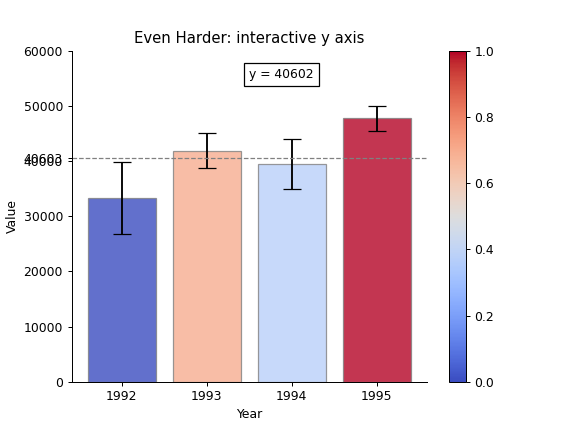

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib.colors as col
import matplotlib.cm as cm
import seaborn as sns

%matplotlib notebook

# Use the following data for this assignment:
np.random.seed(12345)

df = pd.DataFrame([
    np.random.normal(32000, 200000, 3650),
    np.random.normal(43000, 100000, 3650),
    np.random.normal(43500, 140000, 3650),
    np.random.normal(48000, 70000, 3650)
],
                  index=[1992, 1993, 1994, 1995])

# Get the means and standard deviations
df_mean = df.mean(axis=1)
df_std = df.std(axis=1)

n = df.shape[1]

# y default
mean = np.mean(df_mean.values)
y = mean

# Compute the 95% confidence intervals
yerr = df_std / np.sqrt(n) * st.norm.ppf(1 - 0.05 / 2)
conf_ints = [
    st.norm.interval(alpha=0.95, loc=mu, scale=se)
    for mu, se in zip(df_mean, df_std / np.sqrt(n))
]


# Compute the probablility of the mean > y for each column
def compute_probs(y, conf_int):
    if y < np.min(conf_int):
        result = 1.0
    elif y > np.max(conf_int):
        result = 0.0
    else:
        result = (np.max(conf_int) - y) / (np.max(conf_int) - np.min(conf_int))
    return result


# Compute probabilities
probs = [compute_probs(y, ci) for ci in conf_ints]

# Setup the colormap
cc = ['seismic', 'bwr', 'coolwarm']
cmap = cm.get_cmap(cc[2])
cpick = cm.ScalarMappable(cmap=cmap, norm=col.Normalize(vmin=0, vmax=1.0))
cpick.set_array([])

# Setup the plot
plt.figure()
bars = plt.bar(
    range(len(df)),
    df_mean,
    #                width=1,
    edgecolor='gray',
    yerr=yerr,
    alpha=0.8,
    color=cpick.to_rgba(probs),
    capsize=7)

# Add the colorbar
cbar = plt.colorbar(cpick, orientation="vertical")  # "horizontal"

# Turn off some plot rectangle spines
[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'right']]

# Add the horizontal line
hoz_line = plt.axhline(y=y, color='gray', linewidth=1, linestyle='--')

# Set ticks and labels
plt.title('Even Harder: interactive y axis')

plt.xlabel('Year')
plt.ylabel('Value')

plt.xticks(range(len(df)), df.index)
yt_o = plt.gca().get_yticks()
yt = np.append(yt_o, y)
plt.gca().set_yticks(yt)
y_text = plt.text(1.5, 55000, 'y = %d' % y, bbox=dict(fc='white', ec='k'))


# Add interactivity
def onclick(event):
    y = event.ydata
    hoz_line.set_ydata(event.ydata)
    yt = np.append(yt_o, y)
    plt.gca().set_yticks(yt)
    y_text = plt.text(1.5, 55000, 'y = %d' % y, bbox=dict(fc='white', ec='k'))

    probs = [compute_probs(y, ci) for ci in conf_ints]
    for i in range(len(df)):
        bars[i].set_color(cpick.to_rgba(probs[i]))
        bars[i].set_edgecolor('gray')


plt.gcf().canvas.mpl_connect('button_press_event', onclick);

<IPython.core.display.Javascript object>


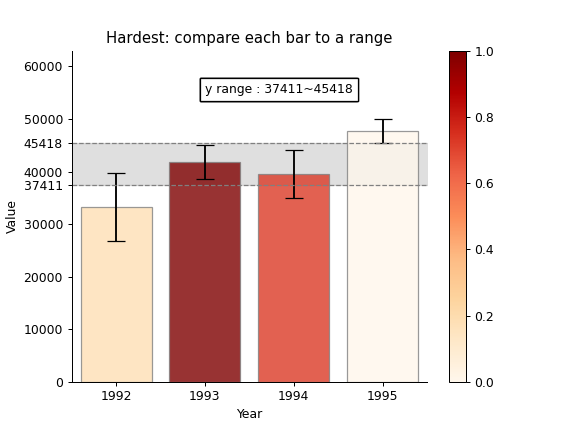

9

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib.colors as col
import matplotlib.cm as cm

%matplotlib notebook

# Use the following data for this assignment:
np.random.seed(12345)

df = pd.DataFrame([
    np.random.normal(32000, 200000, 3650),
    np.random.normal(43000, 100000, 3650),
    np.random.normal(43500, 140000, 3650),
    np.random.normal(48000, 70000, 3650)
],
                  index=[1992, 1993, 1994, 1995])

# Get the means and standard deviations
df_mean = df.mean(axis=1)
df_std = df.std(axis=1)

n = df.shape[1]

# y default
mean = np.mean(df_mean.values)
yu = mean + 5000
yd = mean - 5000
ys = [yu, yd]

# Compute the 95% confidence intervals
yerr = df_std / np.sqrt(n) * st.norm.ppf(1 - 0.05 / 2)
conf_ints = [
    st.norm.interval(alpha=0.95, loc=mu, scale=se)
    for mu, se in zip(df_mean, df_std / np.sqrt(n))
]


# Compute the probablility in the y-range for each column
def compute_probs(ys, conf_int):
    yu = max(ys)
    yd = min(ys)
    if yd <= np.min(conf_int) and yu >= np.max(conf_int):
        result = 1.0
    elif yu <= np.min(conf_int) or yd >= np.max(conf_int):
        result = 0.0
    elif yu >= np.max(conf_int):
        result = (np.max(conf_int) - yd) / (np.max(conf_int) -
                                            np.min(conf_int))
    else:
        result = (yu - np.min(conf_int)) / (np.max(conf_int) -
                                            np.min(conf_int))
    return result


# Compute probabilities
probs = [compute_probs(ys, ci) for ci in conf_ints]

# Setup the colormap
cc = ['seismic', 'bwr', 'coolwarm']
cmap = cm.get_cmap('OrRd')
cpick = cm.ScalarMappable(cmap=cmap, norm=col.Normalize(vmin=0, vmax=1.0))
cpick.set_array([])

# Setup the plot
plt.figure()
bars = plt.bar(
    range(len(df)),
    df_mean,
    #                width=1,
    edgecolor='gray',
    yerr=yerr,
    alpha=0.8,
    color=cpick.to_rgba(probs),
    capsize=7)

# Add the colorbar
cbar = plt.colorbar(cpick, orientation="vertical")  # "horizontal"

# Turn off some plot rectangle spines
[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'right']]

# Add the horizontal line
hoz_line_u = plt.axhline(y=yu, color='gray', linewidth=1, linestyle='--')
hoz_line_d = plt.axhline(y=yd, color='gray', linewidth=1, linestyle='--')
plt.fill_between(range(-1, len(df) + 1), yd, yu, color='gray', alpha=0.25)

# Set ticks,labels, xlim, title...
plt.title('Hardest: compare each bar to a range')

plt.xlabel('Year')
plt.ylabel('Value')

plt.xlim(-0.5, 3.5)

plt.xticks(range(len(df)), df.index)
yt_o = plt.gca().get_yticks()
yt = np.append(yt_o, ys)
plt.gca().set_yticks(yt)
y_text = plt.text(1,
                  55000,
                  "y range : {:.0f}~{:.0f}".format(yd, yu),
                  bbox=dict(fc='white', ec='k'))


# Add interactivity
def onclick(event):

    yu = max(ys)
    yd = min(ys)

    plt.fill_between(range(-1, len(df) + 1), 0, 60000, color='white', alpha=1)
    y = event.ydata

    if abs(y - yu) > abs(y - yd):
        yd = y
        ys[1] = y
        hoz_line_d.set_ydata(yd)
    else:
        yu = y
        ys[0] = y
        hoz_line_u.set_ydata(yu)
    plt.fill_between(range(-1, len(df) + 1), yd, yu, color='gray', alpha=0.25)

    yt = np.append(yt_o, ys)
    plt.gca().set_yticks(yt)
    y_text = plt.text(1,
                      55000,
                      "y range : {:.0f}~{:.0f}".format(yd, yu),
                      bbox=dict(fc='white', ec='k'))

    probs = [compute_probs(ys, ci) for ci in conf_ints]
    for i in range(len(df)):
        bars[i].set_color(cpick.to_rgba(probs[i]))
        bars[i].set_edgecolor('gray')


plt.gcf().canvas.mpl_connect('button_press_event', onclick);